## NYC Green Taxi Analysis
Following analysis investigates transaction level data on NYC Green Taxi Cabs for September of 2015. We first investigate any irregularities in the data and clean them for further analysis. We then look at characteristics of trips, tips as a percentage of payment, and methods to discover anomalies in the data. Please make sure the following packages are properly installed in python27 to run the script. 


In [103]:
##Importing packages, setup
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
##geopy is used to calculate distance between two coordinates
from geopy import distance 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random 
import statsmodels.api as smapi
import statsmodels.graphics as smgraphics
from statsmodels.formula.api import ols

In [2]:
##Downloading data, we keep raw data just to compare it versus our cleaned data
##Df is cleaned data that drop obvious data errors to answer questions here for the case 
df_raw = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')
df = df_raw.copy()

### Data Cleaning
Below are cleaning operations done to the data.  EDA conducted to rule out these data is included at the end in appendix to keep the report concise
    1. Rename columns to lower case & delete white spaces to establish consistency
    2. Drop NAs(4 rows in trip_type) 
    3. Drop duplicates in case of data error. None were present in this data
    4. Drop nonpositive fares 
    5. Drop 0 longtidue and latitudes
    6. Cast datetime columns to appropriate datatime class
    7. Drop rows with same exact pick and and drop off

In [3]:
##1. Rename columns to all lower case for consistency
df.columns = [i.lower() for i in df.columns]
df.columns = df.columns.str.replace(' ', '')

##2. Drop nas, exclude ehail_fee column which is all null 
df=df.loc[:, df.columns != 'ehail_fee'].dropna()

##3. Drop Duplicates
df.drop_duplicates(inplace=True)

##4. Drop negative fares, and 5. nonpositive latitudes and longitudes
df = df[((df.total_amount>0) & (df.dropoff_longitude!=0) & (df.dropoff_latitude!=0) & 
       (df.pickup_longitude!=0) & (df.pickup_latitude!=0)
        )]

##6. Cast datetime columns as datetime
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

##7. drop rows that have same pickup and drop off 
df = df[((df['pickup_latitude'] != df['dropoff_latitude']) |(df['dropoff_longitude'] !=df['dropoff_longitude']))]

### Derived Columns & Defined Functions & Feature Engineering
To make the data understandable by ML algorithms and to increase consistency of the data, we are going to do some derived calculations. For example, there are lots of 0 mile trips which raise obvious red flags. For 0 mile trip_distances we will manually calculate the distance between originating coordinates to destination cooridnates. Below are all the derived columns.
    1. Hour of day from datetime stamp and month of day from datetime stamp
    2. Distance calculated from originating coordinates to destination coordinates (to replace 0 distance)
    3. Replace 0 trip_distance by distance_calculated
    4. Tip as a percentage of total cost
    5. One-hot encoding for factors
    6. Identify if pickup or dropoffs are from airports
    
We will also define our functions here to be used throughout the report.


In [4]:
def distance_calc( lat1, long1, lat2,long2):
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)
    return distance.distance(coords_1, coords_2).miles

In [5]:
def close_to_nyc_airport(lat1,long1):
    """Returns true if a provided coordinates are within 3 miles of JFK,EWR and withiin 2 miles of LGA coordinates
    
    Below are latitude, longtidue tuples of NYC airports
        1. JFK: 40.6413° N, 73.7781° W
        2. EWR: 40.6895° N, 74.1745° W
        3. LGA: 40.7769° N, 73.8740° W
    
    Args: 
        lat1 - latitutde of a coordinate to compare against airport coordinates
        long1 - longitude of a coordinate to compare against airport coordinates

    Returns: 
        'JFK' - is within 2 mile destine from JFK
        'EWR' - is within 2 mile destine from EWR
        'LGA' - is within 2 mile destine from LGA
        'np.NaN' - if input has type errors, i.e. it's not a float or it is not close to any of the three airports       
    
    """
    if((not isinstance(lat1,float))or(not isinstance(long1,float))):
        return np.NaN
    if (distance_calc(lat1,long1,40.6413,-73.7781)<2):
        return 'JFK'
    elif (distance_calc(lat1,long1,40.6895,-74.1745)<2):
        return 'EWR'
    elif (distance_calc(lat1,long1,40.7769,-73.8740)<2):
        return 'LGA'
    else:
        return np.NaN

In [6]:
###1. Hour of day and month from datetime stamp
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour

In [7]:
###2. Distance calculated from originating cooridnates to destination coordinates
df['distance_calculated'] = df.apply(lambda x: distance_calc(x['pickup_latitude'],x['pickup_longitude'],
                                                            x['dropoff_latitude'], x['dropoff_longitude']),axis=1)
df['dropoff_airport'] = df.apply(lambda x: close_to_nyc_airport(x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
df['pickup_airport'] = df.apply(lambda x: close_to_nyc_airport(x['pickup_latitude'], x['pickup_longitude']), axis=1)
df['is_airport_trip'] = (( ~df['dropoff_airport'].isnull()) | ( ~df['pickup_airport'].isnull())).astype(int)

In [4]:
###3. Replace 0 trip_distance by distance_calculated
df['trip_distance_adjusted']  = df['trip_distance']
df['trip_distance_adjusted'][df['trip_distance_adjusted'] ==0] = df[df['trip_distance_adjusted'] ==0]['distance_calculated'] 

In [7]:
###4. Tip as a percentage of total amount
df['tip_percentage'] = df['tip_amount']/df['total_amount']

In [13]:
###5. One hot encoding for factors, please refer to appendix for intuition behind inclusion of these factors for modeling
payment_type = pd.get_dummies(df['payment_type'],prefix='payment_type')
pickup_hour = pd.get_dummies(df['pickup_hour'],prefix='pickup_hour')
dropoff_hour = pd.get_dummies(df['dropoff_hour'],prefix='dropoff_hour')
pickup_month = pd.get_dummies(df['pickup_month'],prefix='pickup_month')
dropoff_month = pd.get_dummies(df['dropoff_month'],prefix='dropoff_month')
ratecodeid = pd.get_dummies(df['ratecodeid'],prefix='ratecodeid')
trip_type = pd.get_dummies(df['trip_type'],prefix='trip_type')
pickup_airport = pd.get_dummies(df['pickup_airport'],prefix='pickup_airport')
dropoff_airport = pd.get_dummies(df['dropoff_airport'],prefix='dropoff_airport')
df = pd.concat([df,payment_type,pickup_hour,dropoff_hour,pickup_month,dropoff_month,ratecodeid,trip_type,
               pickup_airport,dropoff_airport],axis=1)

### Question 1. Report # of rows and columns

In [15]:
print('**Original data**\nnumber of rows: {}\nnumber of columns: {}'.format(df_raw.shape[0],df_raw.shape[1]))
print('\n**Cleaned data**\nnumber of rows: {}\nnumber of columns: {}'.format(df.shape[0],df.shape[1]))

**Original data**
number of rows: 1494926
number of columns: 21

**Cleaned data**
number of rows: 1481825
number of columns: 100


### Question 2.  Plot a histogram of the number of the trip distance (“Trip Distance”)

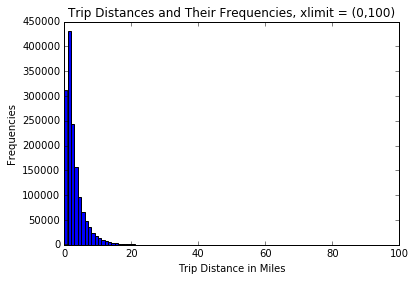

In [16]:
plt.hist(df.trip_distance, bins=range(int(min(df.trip_distance)), int(max(df.trip_distance)),1))
plt.xlim(df.trip_distance.min(),100)
plt.margins(x=0.5)
plt.title("Trip Distances and Their Frequencies, xlimit = (0,100)")
plt.xlabel('Trip Distance in Miles')
plt.ylabel('Frequencies')

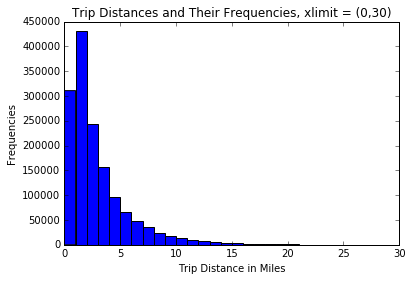

In [17]:
plt.hist(df.trip_distance, bins=range(int(min(df.trip_distance)), int(max(df.trip_distance)),1))
plt.xlim(df.trip_distance.min(),30)
plt.margins(x=0.5)
plt.title("Trip Distances and Their Frequencies, xlimit = (0,30)")
plt.xlabel('Trip Distance in Miles')
plt.ylabel('Frequencies')

### Structure
Few things to keep in note are.
    1. Frequencies decrease as trip distance increases. This makes sense since most trips from NYC are going to be within the city and therefore short.
    2. There are lots of zero mile trips. These are likely due to rounding-down of the miles. Also, a good portion of them can be from data entry errors. For example, we removed 0 longitude and latittude data from our dataset and those rows also had 0 for  distance traveled.

### Question 3 Mean and Median of Trip Distances

In [18]:
###Since directions isn't clear we will use dropoff to use as groupby
df.groupby('dropoff_hour')['trip_distance'].agg({'median':np.median, 'sum':np.mean})

,sum,median
dropoff_hour,,
0,3.250623,2.29
1,3.140066,2.21
2,3.157444,2.22
3,3.238939,2.28
4,3.481026,2.40
5,4.218168,2.96
6,3.953745,2.78
7,3.234353,2.07
8,2.935197,1.89


Some observations from the above data is that we tend to see longer trips late into the night. This makes sense since people are less likely to use inconvinient methods for their commute if their trips are far as they get more tired, potentially drunk after socializing. Also, they would have less public transportation options. 

### Question 3.2 Airport Trips

Since we have location coordinates we can identify the commonly used airports around new york city and use their coordinates.

Three most commonly used airports in NYC are JKF, LaGuardia(LGA) and Newark(EWR) airports. Following are their coordinates. It is arranged in latitude, longtidue order. 
    1. JFK: 40.6413° N, 73.7781° W
    2. EWR: 40.6895° N, 74.1745° W
    3. LGA: 40.7769° N, 73.8740° W

We will use geopy to calculate distance from the coordinates to the airports to see if they were airport related trips. 

While the drop off zone should be around one mile in radius, we will use distance that is less than two miles of distance from airports as a threshold to flag airport trips to avoid false negatives. 

In [19]:
###Since directions isn't clear we will use dropoff to use as groupby
df.groupby('dropoff_airport').apply(lambda x: pd.Series({
      'count'       : len(x),
      'average_fare' : x['total_amount'].mean(),
  })
)

,average_fare,count
dropoff_airport,,
EWR,97.433270,734.0
JFK,46.851993,14144.0
LGA,14.917963,92567.0


In [20]:
###Since directions isn't clear we will use dropoff to use as groupby
df.groupby('pickup_airport').apply(lambda x: pd.Series({
      'count'       : len(x),
      'average_fare' : x['total_amount'].mean(),
  })
)

,average_fare,count
pickup_airport,,
EWR,71.350222,45.0
JFK,37.100185,433.0
LGA,12.861803,48008.0


In [45]:
###Since directions isn't clear we will use dropoff to use as groupby
trips_by_hr = df[df.is_airport_trip==1].groupby('pickup_hour').apply(lambda x: pd.Series({
      'count'       : len(x)
  })
)

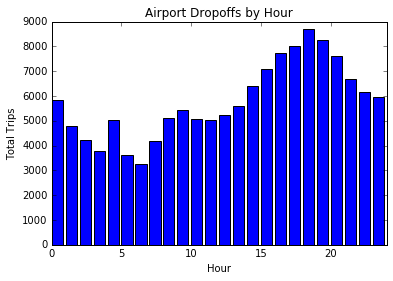

In [62]:
plt.bar( trips_by_hr.index,trips_by_hr['count'])
plt.xlim(0,24)
plt.margins(x=0.5)
plt.title("Airport Dropoffs by Hour")
plt.xlabel('Hour')
plt.ylabel('Total Trips')

The distribution and the count of trips make logical sense. Average trips to EWR is very expensive since to go to NJ you have to cross the toll-gates. Therefore, not many people use cabs as a method of transportation to get to EWR as opposed to LGA which is cheaper to get to especially if you live in less densely populated areas of NYC such as flushing. However, the distribuion seems a bit extreme. LGA is a small airport and is close to residential areas, so we may be picking up some false positives here. Also one would think there is more traffic to JFK, which is one of the busiest airports in the US. Some investigation would be useful. 

Additionally, we plot airport dropoff frequencies by hour. decreasing number of trips in the very early hours are observed which is to be expected. Trips peak around 6-8pm. 

### Question 4 Derived Variable

Tip percentage is derived in the feature engineering section. I simply took the tip amount / total fare. 

In this section, I will employ two different regression methods, ElasticNet and Randomforest and use cross-validation to tune the hyperparameters and choose the winning method. Then we train on the entire training set and confirm that the model that won out is able to generalize well on data it hasn't seen. Please note that I use minimal combination of hyperparameters since my computation resources are lacking.

RF and ElasticNet were chosen because both of these models train really fast as opposed to gradient boosting for example. So, I would be able to cross-validate and tune parameters more easily. Also both of these models can be interpreted easily using feature importance and looking at coefficients. Additionally, feature selection is easier with their built-in regularization methods.

In [26]:
##variable was already derived in the earlier section.

In [8]:
###Set seed
random.seed(1)

In [11]:
###Target
y_r = df['tip_percentage']
###Exclude columns not included in our model
X = df.drop(['vendorid','lpep_pickup_datetime','lpep_dropoff_datetime','store_and_fwd_flag','ratecodeid','tip_percentage',
             'dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','trip_distance','tip_amount',
             'total_amount','pickup_hour','dropoff_hour','trip_type','distance_calculated','dropoff_airport','pickup_airport','is_airport_trip'],axis=1)

In [12]:
### Train test split. 80% training set, 20% test set
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X,y_r,test_size=.2,random_state=42)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
##Conducting parameter tuning and k-fold cross validation using GridSearchCV on a training set
##We can train more combinations of hyperparameters but I'm only trying a few because of lacking computational resources
params_en = {'l1_ratio':[.1,.5,.9,1]}
en =GridSearchCV(ElasticNet(),params_en,cv=4).fit(X_train_r,y_train_r)
params_rf = {'n_estimators':[5,50,100]}
rf = GridSearchCV(ensemble.RandomForestRegressor(),params_rf,cv=4).fit(X_train_r,y_train_r)

In [15]:
##Randomforest has a significantly higher score. It's best hyperparamter was 100 n_estimators.
print('en best R2 score : {:.4f}'.format(en.best_score_))
print('en best params: {}'.format(en.best_params_))
print('rf best R2 score : {:.4f}'.format(rf.best_score_))
print('rf best params: {}'.format(rf.best_params_))

en best R2 score : 0.0006
en best params: {'l1_ratio': 0.1}
rf best R2 score : 0.5793
rf best params: {'n_estimators': 100}


In [21]:
##Train our model with the best parameters on the full training set
en_fin =ElasticNet(l1_ratio=0.1).fit(X_train_r,y_train_r)
rf_fin = ensemble.RandomForestRegressor(n_estimators=100).fit(X_train_r,y_train_r)

In [36]:
##Confirm performance on test-set
print('ElasticNet RMSE : {:.4f}'.format(np.sqrt(mean_squared_error(y_test_r, en_fin.predict(X_test_r)))))
print('RandomForest RMSE : {:.4f}'.format(np.sqrt(mean_squared_error(y_test_r, rf_fin.predict(X_test_r)))))
print('ElasticNet R^2 : {:.4f}'.format(en_fin.score(X_test_r,y_test_r)))
print('RandomForest R^2 : {:.4f}'.format(rf_fin.score(X_test_r,y_test_r)))

ElasticNet RMSE : 0.0882
RandomForest RMSE : 0.0572
ElasticNet R^2 : 0.0006
RandomForest R^2 : 0.5794


We confirm that RF is a superior model since it has both smaller error as well as higher R^2 score. We train this on our entire cleaned dataset for a production model.

In [ ]:
##Train best model on full dataset
rf_production = RandomForestRegressor(n_estimators=100).fit(X,y)

### Question 5. Anomaly Detection
Within the context of how this data would be useful for Capital One, being able to detect unusually large charges on credit cards can be useful insight to protect the card customers. In this exercise, we will model out total fare as a function of distance traveled and use linear model diagnostics to detect outliers. In particular we will calculate p-value using studentized distriution on residuals after making bonferroni adjustments. Values that are unusually different will be pointed out using this method

In [14]:
##Picking out just thousand rows for demonstration and quicker computation
df_ols = df.sample(1000)

In [87]:
regression = ols("data ~ x", data=dict(data=df_ols['total_amount'], x=df_ols['trip_distance_adjusted'])).fit()

In [88]:
figure = smgraphics.regressionplots.plot_fit(regression, 1)
plt.close()

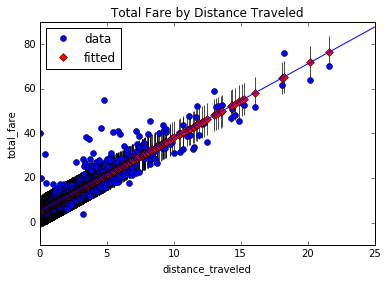

In [89]:
ax = figure.axes[0]
ax.set_xlabel('distance_traveled')
ax.set_ylabel('total_fare')
ax.set_title('Total Fare by Distance Traveled')
smgraphics.regressionplots.abline_plot(model_results=regression, ax=figure.axes[0])


In [44]:
test = regression.outlier_test()

In [96]:
outliers = test[test['bonf(p)']<.05].join(df_ols,how='inner')

In [99]:
outliers[['trip_distance_adjusted','total_amount']]

,trip_distance_adjusted,total_amount
492788,3.700000,37.34
935731,5.440000,40.69
1259227,6.020000,39.80
559265,5.800000,41.16
1324698,3.430000,38.16
1096713,0.003445,40.29
786550,4.800000,54.80
1406162,4.600000,42.30
58678,0.416804,30.80


We were able to identify 9 outliers. These are trips where a customer is charged unusually high amount of money for the distance traveled. They might be due to extreme traffic or other reasons, but we can start from here as a starting point to investigate anomalies.

# Appendix

### Appendix A. Why we can't use ratecodeid to identify airport trips
Some ratecodeid inputs such as 2 and 3 are reserved for airport trips(JFK and EWR respectively). However, upon observation of the coordinates of these trips it was apparent that only about half of them actually lead to airports. For example, 
After observing some of the datapoints, it's very apparent we can't use ratecodeid reliably to identify 

For example, the first row below is a trip from main part of Queens to Flushing which is far from newark airport. These data errors can be a result from false input from cab drivers to artificially increase the fares, simple mistakes or data collection errors. Either way, it is not a reliable way to detect airport trips. Therefore, we will calculate the distances to the coordinates instead.

In [184]:
df[df.ratecodeid == 3].head(3)

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,improvement_surcharge,total_amount,payment_type,trip_type,pickup_hour,dropoff_hour,test,drop_off_airport,dropoff_airport,pickup_airport
3934,2,2015-09-01 06:43:28,2015-09-01 06:43:28,N,3,-73.801819,40.706917,-73.833527,40.766567,5,...,0.3,53.30,1,1.0,6,6,1657.053076,False,NaN,NaN
4173,2,2015-09-01 07:16:00,2015-09-01 07:16:00,N,3,-73.913841,40.687027,-74.181526,40.687737,5,...,0.3,84.05,2,1.0,7,7,1655.434164,False,NaN,NaN
4180,2,2015-09-01 07:19:23,2015-09-01 07:19:23,N,3,-73.942932,40.821476,-74.183434,40.688156,1,...,0.3,103.30,2,1.0,7,7,1666.392901,False,NaN,NaN


### Appendix B. Exploratory Data Analysis for Data Irregularities

In [102]:
##First we investigate distributions of the columns, we notice column name cases are inconsistent
##i.e. improvement surcharge. We will lowercase the column names to keep it consistent and easy to manipulate
##We notice none of the columns have null values except Ehail_fee. 
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To